In [8]:
import os
import glob
import numpy as np
from pyhail import hdr, mesh, common, hsda
import pyart
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

In [9]:
#configurations for HSDA retrieval
hca_hail_idx = [9, 10] #list of hail classe(s) indices in HCA
dzdr         = 0 #ZDR offset (used to correct calibration)

#grid configuration required for calculating MESH
grid_shape  = (41, 201, 201)
grid_limits = ((0, 20000), (-100000.0, 100000.0), (-100000.0, 100000.0))
grid_roi    = 2000

In [10]:
def calc_beam_blocking(radar_ffn, srtm_ffn):
    """
    Calculate cumulative beam blocking for radar volume - used for HSDA calculation
    """
    
    #load radar object
    try:
        if ".h5" in radar_ffn:
            radar = pyart.aux_io.read_odim_h5(radar_ffn)
        elif ".nc" or ".mdv" in radar_ffn:
            radar      = pyart.io.read(radar_ffn)
    except:
        print('file failed: ',radar_ffn)
        return None
    
    cbb_meta = common.beam_blocking(radar, srtm_ffn)
    
    return cbb_meta

def _adjust_csu_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the hydrometeor classification.
    """
    cb.set_ticks(np.linspace(0, 10, 11))
    cb.ax.set_yticklabels(
        [
            "None",
            "Driz",
            "Rain",
            "IceCry",
            "IceAgg",
            "W Snow",
            "V Ice",
            "LD Gpl",
            "HD Gpl",
            "Hail",
            "Melt Hail",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb


def _adjust_hsda_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the HSDA classification.
    """
    cb.set_ticks(np.linspace(0, 3, 4))
    cb.ax.set_yticklabels(
        [
            "None",
            "SH (<25mm)",
            "LH (25-50mm)",
            "GH (>50mm)",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def build_cmaps():
    """
    This function retruns the discrete colourmaps used in the pipeline
    """
    hca_colors = [
    "White",
    "LightBlue",
    "SteelBlue",
    "MediumBlue",
    "Plum",
    "MediumPurple",
    "m",
    "Green",
    "YellowGreen",
    "Gold",
    "Red",
    ]
    hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
    hca_cmap = colors.ListedColormap(hca_colors)  
    hsda_cmap = colors.ListedColormap(hsda_colors) 
    return hca_cmap, hsda_cmap

In [11]:
def pipeline(radar_file_name):

    ###########################################################
    # Preprocessing
    ###########################################################
    
    #load radar object
    radar = pyart.io.read(radar_file_name)
    #load instrument data
    radar_name = radar.metadata['instrument_name']
    #extract date    
    dt       = datetime.strptime(radar.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

    #build sounding data
    snd_data = np.load(sounding_fn)
    snd_dict = {'t':snd_data["t"], 'z':snd_data["z"], 'r':snd_data["r"]}
    mesh_levels = [snd_data["fz_level"], snd_data["minus_20_level"]]
    
    #add cbb data
    radar.add_field('cbb', cbb_meta, replace_existing=True)
    
    ###########################################################
    # Polarimetric Hail Size Retrievals
    ###########################################################
    
    #HSDA
    hsda_meta = hsda.main(radar, snd_dict, hca_hail_idx)
    radar.add_field('hsda', hsda_meta, replace_existing=True) 
    
    #HDR
    #build radar data dict
    dbz = radar.fields['corrected_reflectivity']['data']
    zdr = radar.fields['corrected_differential_reflectivity']['data']
    radar_dict = {'dbz':dbz, 'zdr':zdr}
    hdr_meta, hdr_size_meta = hdr.main(radar_dict)
    radar.add_field('hdr', hdr_meta, replace_existing=True)
    radar.add_field('hdr_size', hdr_size_meta, replace_existing=True)
    

    ###########################################################
    # Plotting
    ###########################################################
 
    hca_cmap, hsda_cmap = build_cmaps()
    
    fig = plt.figure(figsize=[18,16])
    tilt = 7
    max_lat = -37.7
    min_lat = -38
    max_lon = 145.3
    min_lon = 145.0
    display = pyart.graph.RadarMapDisplay(radar)
    
    ax=plt.subplot(331, projection=ccrs.PlateCarree())
    display.plot_ppi_map('corrected_reflectivity',tilt, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ax=plt.subplot(332, projection=ccrs.PlateCarree())
    display.plot_ppi_map('corrected_differential_reflectivity',tilt, vmin=-1, vmax=6, resolution = '10m',
                        max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ax=plt.subplot(333, projection=ccrs.PlateCarree())
    display.plot_ppi_map('corrected_specific_differential_phase',tilt, vmin=0, vmax=8, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ax=plt.subplot(334, projection=ccrs.PlateCarree())
    display.plot_ppi_map('cross_correlation_ratio',tilt, vmin=0.8, vmax=1.05, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ax=plt.subplot(335, projection=ccrs.PlateCarree())
    display.plot_ppi_map('radar_echo_classification',tilt, vmin=-0.5, vmax=10.5, cmap=hca_cmap, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    display.cbs[-1] = _adjust_csu_scheme_colorbar_for_pyart(display.cbs[-1])
    
    ax=plt.subplot(336, projection=ccrs.PlateCarree())
    display.plot_ppi_map('hsda', tilt, vmin=-0.5, vmax=3.5, cmap=hsda_cmap, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    display.cbs[-1] = _adjust_hsda_scheme_colorbar_for_pyart(display.cbs[-1])
    
    ax=plt.subplot(337, projection=ccrs.PlateCarree())
    display.plot_ppi_map('hdr_size', tilt, vmin=0, vmax=50, resolution = '10m', cmap='hot_r',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ax=plt.subplot(338, projection=ccrs.PlateCarree())
    display.plot_ppi_map('cbb', tilt, vmin=0, vmax=1, resolution = '10m',
                         max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon)
    
    ###########################################################
    # Generated gridded reflectivity for MESH and plot
    ###########################################################
    
    #genreate grid object for cts fields
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        weighting_function = 'Barnes',
        gridding_algo = 'map_gates_to_grid',
        roi_func='constant', constant_roi = grid_roi,
        fields=['corrected_reflectivity'])
    
    #MESH, saving to file and ignoring output
    grid = mesh.main(grid, ref_name='corrected_reflectivity', temph_data=mesh_levels, mesh_method='mh2019_95')
    
    #plot MESH
    ax=plt.subplot(339, projection=ccrs.PlateCarree())
    display_grid = pyart.graph.GridMapDisplay(grid)
    display_grid.plot_grid('mesh', 0, vmin=0, vmax=50, ax = ax, cmap='hot_r')
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    
    #save to file
    plt.savefig(out_path + '/example.jpeg', dpi=75)
    print('completed')

beamwidth info missing form volume, using default of 1deg
completed


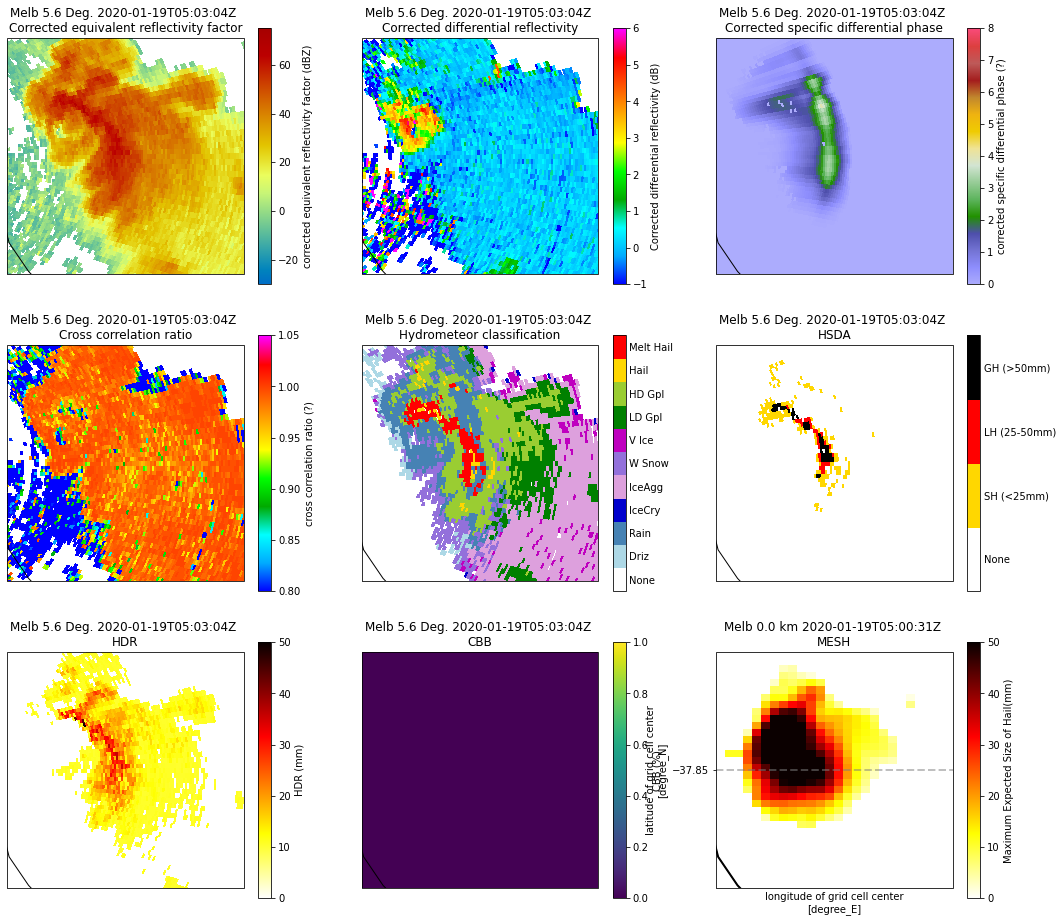

In [12]:
#define paths
srtm_fn    = 'example_data/melb_500m_dem.tif'
sounding_fn = 'example_data/melb_20200119_era5_sounding.npz'
radar_fn    = 'example_data/02_20200119_050031_level1b_ppi.nc'
out_path    = 'output_data'
if not os.path.exists(out_path):
        os.makedirs(out_path)
        
#calculate cumulative beam blocking fraction CBB
cbb_meta = calc_beam_blocking(radar_fn, srtm_fn)

#run pipeline
pipeline(radar_fn)